# 树模型

RF of ET:ET


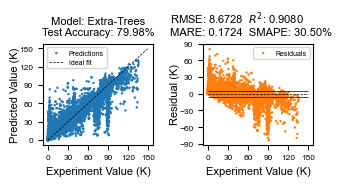

程序运行完成，总耗时：179.81 秒


In [4]:
import pandas as pd
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from joblib import dump
import matplotlib.pyplot as plt
import numpy as np
import time

#输出，模型文件、特征名文件、性能图片
# 定义路径常量
DATA_PATH = '../../Data/mdr_clean_od2.csv'
MODEL_PATH = '2-model'
name = input("RF of ET:")
FEATURE_NAMES_PATH = f'./{MODEL_PATH}/{name}_feature_od.joblib'#修改输出文件
MODEL_JOBLIB_PATH = f'./{MODEL_PATH}/{name}_od.joblib'

if not os.path.exists(f'./{MODEL_PATH}'):
    os.makedirs(f'./{MODEL_PATH}')

# 化学式拆分为字典
def parse_formula(formula):
    formula = str(formula)  # 确保formula是字符串
    elements_ratios = {}
    for element, ratio in re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula):
        if element in elements_ratios:
            elements_ratios[element] += float(ratio) if ratio else 1
        else:
            elements_ratios[element] = float(ratio) if ratio else 1
    return elements_ratios

# 数据预处理
def preprocess_molecular_data(df):
    # 获取所有不同的元素
    all_elements = set()
    for formula in df['formula']:  # 通过列名访问数据
        all_elements.update(parse_formula(formula).keys())
    feature_data = []
    target_data = []
    for index, formula in df['formula'].items():  # 通过列名访问数据
        elements_ratios = parse_formula(formula)
        # 对每个元素生成特征行，缺失的元素设为0
        feature_row = {element: elements_ratios.get(element, 0) for element in all_elements}
        feature_data.append(feature_row)     
        # 处理目标列（'Tc'），如果为空则为None
        target_data.append(df.loc[index, 'Tc'] if not pd.isna(df.loc[index, 'Tc']) else None)
    # 返回特征数据（DataFrame）和目标数据（Series）
    return pd.DataFrame(feature_data), pd.Series(target_data)

# 评估预测准确率
def right_count(y_pred, y_true):
    return (abs(y_pred - y_true) < 5).sum()

def mare_c(y_true, y_pred):
    # 只选择真实值>5的样本
    mask = (y_true > 5)
    y_true_nonzero = y_true[mask]
    y_pred_nonzero = y_pred[mask]
    
    if len(y_true_nonzero) == 0:
        return float('nan')  # 如果没有非零样本，返回 NaN 避免错误
    
    return np.mean(np.abs((y_true_nonzero - y_pred_nonzero) / y_true_nonzero))

def smape_c(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    return np.mean(diff / denominator) * 100  # 返回百分比形式

# 性能评估函数
def performancecalculator(trueVals, predVals, name):
    fig_height = 5  #cm
    fig_width = 8.5 #cm
    plt.rcParams['font.family'] = 'Arial'  # 例如，设置为 Arial 字体
    plt.figure(figsize=(fig_width/2.54, fig_height/2.54))
    # mt = max(trueVals)
    # mp = max(predVals)
    mt = 150
    mp = 150
    plt.subplot(1, 2, 1)
    plt.scatter(trueVals, predVals, color='#1f77b4', label='Predictions',s=3,marker='o',edgecolor='none')
    plt.plot([0, mt], [0, mp], 'k--', lw=0.5, label='Ideal fit')
    accuracy = right_count(predVals, trueVals) / len(predVals) * 100
    plt.title(
        f'Model: {name}\n'
        f'Test Accuracy: {accuracy:.2f}%',
        fontsize=8)
    plt.legend(fontsize=5)
    plt.xlabel('Experiment Value (K)',fontsize=8)
    plt.ylabel('Predicted Value (K)',fontsize=8,labelpad=-0.5)
    plt.xticks(fontsize=6)  # 确保所有的x轴标签都能显示
    plt.yticks(fontsize=6)  # 设置y轴标签的字体大小
    plt.xticks(range(0, mt+1, 30))
    plt.yticks(range(0, mt+1, 30))


    plt.subplot(1, 2, 2)
    residuals = predVals - trueVals 
    mare = mare_c(trueVals, predVals)
    smape = smape_c(trueVals, predVals)
    rmse = mean_squared_error(trueVals, predVals, squared=False)
    r2 = r2_score(trueVals, predVals)
    plt.title(
        f'RMSE: {rmse:.4f}  $R^2$: {r2:.4f}\n'
        f'MARE: {mare:.4f}  SMAPE: {smape:.2f}%', 
        fontsize=8, loc='left', x = -3e-1)
    plt.scatter(trueVals, residuals, color='#ff7f0e', label='Residuals',s=3,marker='o',edgecolor='none')
    plt.hlines(y=0, xmin=0, xmax=mt, colors='black', linestyles='dashed',lw=0.5)
    plt.hlines(y=5, xmin=0, xmax=mt, colors='black', linestyles='solid',lw=0.5)
    plt.hlines(y=-5, xmin=0, xmax=mt, colors='black', linestyles='solid',lw=0.5)
    plt.xlabel('Experiment Value (K)',fontsize=8)
    plt.ylabel('Residual (K)',fontsize=8,labelpad=-0.5)
    plt.xticks(fontsize=6)  # 确保所有的x轴标签都能显示
    plt.yticks(fontsize=6)  # 设置y轴标签的字体大小
    plt.xticks(range(0, mt+1, 30))
    plt.yticks(range(-90, 91, 30))
    plt.legend(fontsize=5)
    # 调整布局
    plt.tight_layout()
    plt.savefig(f'../../Pic/Pic/Fig5-{name}_od.svg', bbox_inches='tight', pad_inches=0.05,transparent=True)
    plt.savefig(f'../../Pic/Pic/Fig5-{name}_od.tif', dpi=600, bbox_inches='tight', pad_inches=0.05,transparent=True)
    plt.show()

# 训练和评估模型
def train_evaluate_model(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    performancecalculator(y_test, predictions, name)
#     dump(model, MODEL_JOBLIB_PATH)#修改输出文件

# 主函数
def main():
    # 读取CSV文件
    df = pd.read_csv(DATA_PATH, low_memory=False)

    # 预处理数据
    # 测试集表现
    # X, y = preprocess_molecular_data(df)
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    # 训练集表现
    X_train, y_train = preprocess_molecular_data(df)
    X_test, y_test = preprocess_molecular_data(df)

    # 保存特征列名
#     dump(X_train.columns.tolist(), FEATURE_NAMES_PATH)

    # 使用树模型进行分析
    if name == 'RF':
        train_evaluate_model(RandomForestRegressor(criterion='friedman_mse',max_depth=None,min_samples_leaf=1,
                                                   min_samples_split=2,n_estimators=300), 
                             X_train, y_train, X_test, y_test, 'Random Forest')
    elif name == 'ET':
        train_evaluate_model(ExtraTreesRegressor(criterion='friedman_mse',max_depth=None,min_samples_leaf=1,
                                                 min_samples_split=5,n_estimators=300), 
                             X_train, y_train, X_test, y_test, 'Extra-Trees')
    

if __name__ == "__main__":
    start_time = time.time()
    main()
    end_time = time.time() 
    elapsed_time = end_time - start_time
    print(f"程序运行完成，总耗时：{elapsed_time:.2f} 秒") 

# LM超导预测

In [ ]:
import pandas as pd
import re
from joblib import load
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 定义路径常量
# DATA_PATH = '../../Data/high-Tc.csv'
MODEL_PATH = './2-model'
# MODEL_FILE = 'RF.joblib'
# FEATURE_NAMES_FILE = 'RF_feature.joblib'
# OUTPUT_PATH = './3-prediction/updated_mdr_RF.csv'
MODEL_FILE = 'ET.joblib'
FEATURE_NAMES_FILE = 'ET_feature.joblib'
# OUTPUT_PATH = './3-prediction/updated_mdr_ET.csv'
OUTPUT_PATH = './3-prediction/Ga.csv'
DATA_PATH = './3-prediction/Ga.csv'

if not os.path.exists('./3-prediction'):
    os.makedirs('./3-prediction')

# 化学式拆分为字典
def parse_formula(formula):
    formula = str(formula)
    elements_ratios = {}
    for element, ratio in re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula):
        if ratio == '':
            ratio = 1.0
        else:
            ratio = float(ratio)
        elements_ratios[element] = ratio
    return elements_ratios

# 主函数
def main():
    # 读取CSV文件
    df = pd.read_csv(DATA_PATH)

    # 加载模型和特征名称
    model = load(f'{MODEL_PATH}/{MODEL_FILE}')
    feature_names = load(f'{MODEL_PATH}/{FEATURE_NAMES_FILE}')

    # 将化学式转换为元素特征矩阵
    formula_type = input('input type number of fromula: 1.formula / 2.alloy:  ')
    if formula_type == '1':
        formula_type='formula'
#         pre_type='ET_element'
        pre_type='ET_element'
    elif formula_type == '2':
        formula_type='alloy%'
#         pre_type='ET_alloy'
        pre_type='ET_alloy_wt'
    features_df = pd.DataFrame(df[formula_type].apply(parse_formula).tolist()).fillna(0)
    
    # 只保留模型需要的特征列（缺少的元素填0）
    features_df = features_df.reindex(columns=feature_names, fill_value=0)

    # 批量预测（向量化）
    predicted_temps = model.predict(features_df)

    # 添加预测结果到原始 DataFrame
    df[pre_type] = predicted_temps
    # 保存到新的CSV文件
    df.to_csv(OUTPUT_PATH, index=False)
    print(f"预测完成，结果已保存至 {OUTPUT_PATH}")

if __name__ == "__main__":
    main()

input type number of fromula: 1.formula / 2.alloy:  1
预测完成，结果已保存至 ./3-prediction/updated_High_Tc.csv


# 机器学习模型效果对比
## 决策树回归、梯度提升树回归、随机森林回归

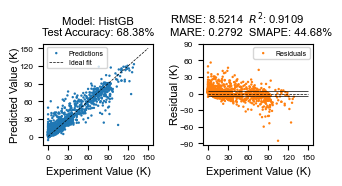

In [3]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from joblib import dump
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# 读取CSV文件
df = pd.read_csv('../../Data/mdr_clean.csv')

# 化学式拆分为字典
def parse_formula(formula):
    formula = str(formula)  # 确保formula是字符串
    elements_ratios = {}
    for element, ratio in re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula):
        if element in elements_ratios:
            elements_ratios[element] += float(ratio) if ratio else 1
        else:
            elements_ratios[element] = float(ratio) if ratio else 1
    return elements_ratios

# 创建分子数据列表
molecular_data = []
for index, formula in df.iloc[1:, 0].items():
    elements_ratios = parse_formula(formula)
    transition_temp = df.iloc[index, 1] if not pd.isna(df.iloc[index, 1]) else None
    molecular_data.append({
        'elements_ratios': elements_ratios,
        'transition_temp': transition_temp
    })

# 预处理数据
def preprocess_molecular_data(molecular_data):
    all_elements = set()
    for data in molecular_data:
        all_elements.update(data['elements_ratios'].keys())

    feature_data = []
    target_data = []

    for data in molecular_data:
        feature_row = {element: data['elements_ratios'].get(element, 0) for element in all_elements}
        feature_data.append(feature_row)
        target_data.append(data['transition_temp'])

    return pd.DataFrame(feature_data), pd.Series(target_data)

X, y = preprocess_molecular_data(molecular_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 评估预测准确率
def right_count(y_pred, y_true):
    relative_error = abs(y_pred - y_true)
    return (relative_error < 5).sum().item()

def mare_c(y_true, y_pred):
    # 只选择真实值>5的样本
    mask = (y_true > 5)
    y_true_nonzero = y_true[mask]
    y_pred_nonzero = y_pred[mask]
    
    if len(y_true_nonzero) == 0:
        return float('nan')  # 如果没有非零样本，返回 NaN 避免错误
    
    return np.mean(np.abs((y_true_nonzero - y_pred_nonzero) / y_true_nonzero))

def smape_c(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    return np.mean(diff / denominator) * 100  # 返回百分比形式

# 性能评估函数
def performancecalculator(trueVals, predVals, name):
    fig_height = 5  #cm
    fig_width = 8.5 #cm
    plt.rcParams['font.family'] = 'Arial'  # 例如，设置为 Arial 字体
    plt.figure(figsize=(fig_width/2.54, fig_height/2.54))
    # mt = max(trueVals)
    # mp = max(predVals)
    mt = 150
    mp = 150
    plt.subplot(1, 2, 1)
    plt.scatter(trueVals, predVals, color='#1f77b4', label='Predictions',s=3,marker='o',edgecolor='none')
    plt.plot([0, mt], [0, mp], 'k--', lw=0.5, label='Ideal fit')
    accuracy = right_count(predVals, trueVals) / len(predVals) * 100
    plt.title(
        f'Model: {name}\n'
        f'Test Accuracy: {accuracy:.2f}%',
        fontsize=8)
    plt.legend(fontsize=5)
    plt.xlabel('Experiment Value (K)',fontsize=8)
    plt.ylabel('Predicted Value (K)',fontsize=8,labelpad=-0.5)
    plt.xticks(fontsize=6)  # 确保所有的x轴标签都能显示
    plt.yticks(fontsize=6)  # 设置y轴标签的字体大小
    plt.xticks(range(0, mt+1, 30))
    plt.yticks(range(0, mt+1, 30))


    plt.subplot(1, 2, 2)
    residuals = predVals - trueVals 
    mare = mare_c(trueVals, predVals)
    smape = smape_c(trueVals, predVals)
    rmse = mean_squared_error(trueVals, predVals, squared=False)
    r2 = r2_score(trueVals, predVals)
    plt.title(
        f'RMSE: {rmse:.4f}  $R^2$: {r2:.4f}\n'
        f'MARE: {mare:.4f}  SMAPE: {smape:.2f}%', 
        fontsize=8, loc='left', x = -3e-1)
    plt.scatter(trueVals, residuals, color='#ff7f0e', label='Residuals',s=3,marker='o',edgecolor='none')
    plt.hlines(y=0, xmin=0, xmax=mt, colors='black', linestyles='dashed',lw=0.5)
    plt.hlines(y=5, xmin=0, xmax=mt, colors='black', linestyles='solid',lw=0.5)
    plt.hlines(y=-5, xmin=0, xmax=mt, colors='black', linestyles='solid',lw=0.5)
    plt.xlabel('Experiment Value (K)',fontsize=8)
    plt.ylabel('Residual (K)',fontsize=8,labelpad=-0.5)
    plt.xticks(fontsize=6)  # 确保所有的x轴标签都能显示
    plt.yticks(fontsize=6)  # 设置y轴标签的字体大小
    plt.xticks(range(0, mt+1, 30))
    plt.yticks(range(-90, 91, 30))
    plt.legend(fontsize=5)
    # 调整布局
    plt.tight_layout()
    plt.savefig(f'./1-model_vs/{name}.svg', dpi=600, bbox_inches='tight', pad_inches=0.05,transparent=True)
    plt.savefig(f'./1-model_vs/{name}.tif', dpi=600, bbox_inches='tight', pad_inches=0.05,transparent=True)
    plt.show()

# 训练和评估模型
def train_evaluate_model(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    performancecalculator(y_test, predictions, name)


# # 使用极端随机树回归
# train_evaluate_model(ExtraTreesRegressor(), X_train, y_train, X_test, y_test, 'Extra-Trees')

# # 使用决策树进行分析
# train_evaluate_model(DecisionTreeRegressor(), X_train, y_train, X_test, y_test, 'Decision Tree')

# # 使用梯度提升回归进行分析
# train_evaluate_model(GradientBoostingRegressor(), X_train, y_train, X_test, y_test, 'Gradient Boosting')

# # 使用随机森林进行分析
# train_evaluate_model(RandomForestRegressor(), X_train, y_train, X_test, y_test, 'Random Forest')

# 使用梯度提升回归进行分析
train_evaluate_model(HistGradientBoostingRegressor(), X_train, y_train, X_test, y_test, 'HistGB')

# # 使用CatBoost回归进行分析
# train_evaluate_model(CatBoostRegressor(), X_train, y_train, X_test, y_test, 'CatBoost') 

# # 使用XGBoost回归进行分析
# train_evaluate_model(XGBRegressor(), X_train, y_train, X_test, y_test, 'XGBoost') 

# # 使用LightGBM进行回归分析
# train_evaluate_model(LGBMRegressor(), X_train, y_train, X_test, y_test, 'LightGBM')